# Heston simulation and distribution

## Time series simulation

In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from fyne import heston


kappa = 5.07
theta = 0.0457
nu = 0.48
rho = -0.767
mu = 0.1

vol = theta
price = 1640

time = 30 / 252
price_grid = np.linspace(1300, 2500)
pdf_prices = [heston.pdf(x, price, time, vol, mu, kappa, theta, nu, rho) for x in price_grid]
pdf_prices_neutral = [heston.pdf(x, price, time, vol, 0, kappa, theta, nu, rho) for x in price_grid]

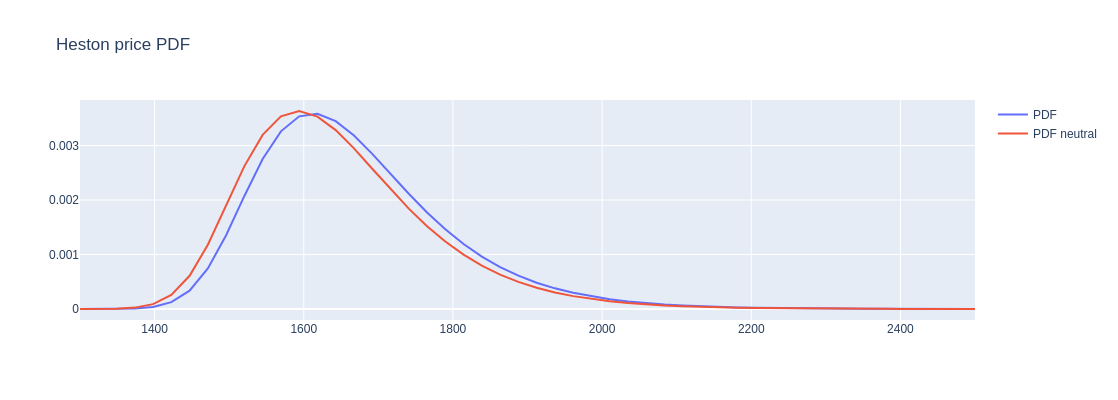

In [2]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=price_grid,
        y=pdf_prices,
        name="PDF",
    )
)
fig.add_trace(
    go.Scatter(
        x=price_grid,
        y=pdf_prices_neutral,
        name="PDF neutral",
    )
)
fig.update_layout(
    title="Heston price PDF",
    height=400,
    width=800,
)
fig.show()

/home/doug/git/fyne/src/fyne/heston.py:806: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

/home/doug/git/fyne/src/fyne/heston.py:806: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

/tmp/ipykernel_2435/3018744677.py:16: IntegrationWarning:

The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.

/tmp/ipykernel_2435/3018744677.py:16: IntegrationWarning:

The integ

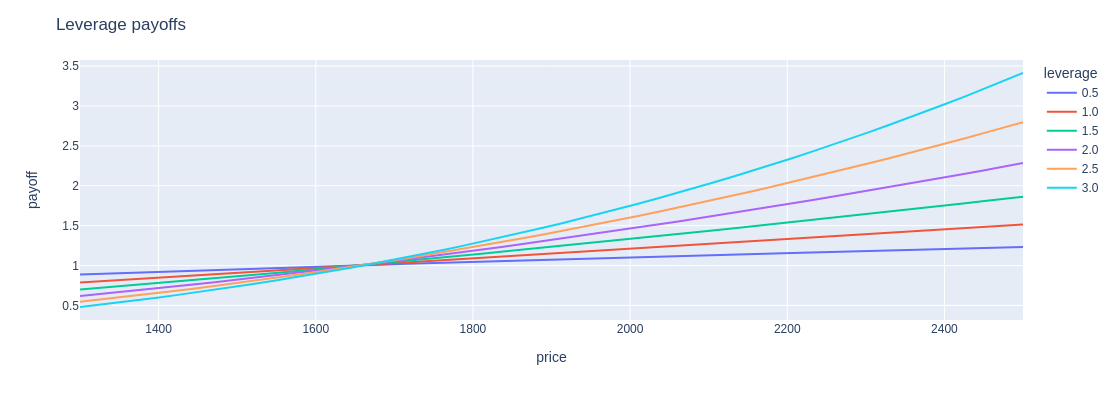

In [3]:
import pandas as pd
import plotly.express as px

from scipy.integrate import quad


def compute_leverage_payoff(x, leverage, price, time, theta):
    return (x / price) ** leverage * np.exp(- 0.5 * leverage * (leverage - 1) * theta ** 2 * time)


def compute_leverage_price(leverage, price, time, vol, kappa, theta, nu, rho):
    def closure(x):
        prob = heston.pdf(x, price, time, vol, 0, kappa, theta, nu, rho)
        payoff = compute_leverage_payoff(x, leverage, price, time, theta)
        return prob * payoff
    return quad(closure, 0, price)[0] + quad(closure, price, np.inf)[0]


leverages = np.array([0.5, 1, 1.5, 2, 2.5, 3])
leverage_payoffs = compute_leverage_payoff(price_grid[:, None], leverages, price, time, theta)
leverage_prices = np.array([compute_leverage_price(leverage, price, time, vol, kappa, theta, nu, rho) for leverage in leverages])
payoffs = pd.DataFrame(
    {
        'payoff': (leverage_payoffs / leverage_prices).ravel(),
        'price': np.broadcast_to(price_grid[:, None], leverage_payoffs.shape).ravel(),
        'leverage': np.broadcast_to(leverages, leverage_payoffs.shape).ravel(),
    }
)
fig = px.line(payoffs, x='price', y='payoff', color='leverage')
fig.update_layout(
    title="Leverage payoffs",
    height=400,
    width=600,
)
fig.show()

/home/doug/git/fyne/src/fyne/heston.py:806: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

/home/doug/git/fyne/src/fyne/heston.py:806: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

/tmp/ipykernel_2435/3018744677.py:16: IntegrationWarning:

The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.

/tmp/ipykernel_2435/3018744677.py:16: IntegrationWarning:

The maxim

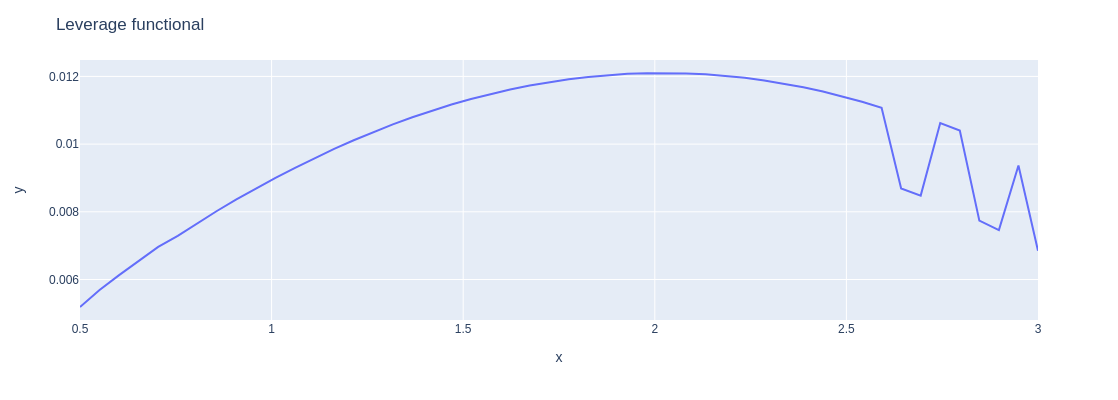

In [4]:
def compute_leverage_functional(leverage, price, time, vol, mu, kappa, theta, nu, rho):
    leverage_price = compute_leverage_price(leverage, price, time, vol, kappa, theta, nu, rho)
    def closure(x):
        prob = heston.pdf(x, price, time, vol, mu, kappa, theta, nu, rho)
        payoff = compute_leverage_payoff(x, leverage, price, time, theta)
        return prob * np.log(payoff / leverage_price)
    return quad(closure, 0, price_grid[-1])[0]

leverages = np.linspace(0.5, 3)
functionals = [compute_leverage_functional(leverage, price, time, vol, mu, kappa, theta, nu, rho) for leverage in leverages]
fig = px.line(x=leverages, y=functionals)
fig.update_layout(
    title="Leverage functional",
    height=400,
    width=600,
)
fig.show()

/home/doug/git/fyne/src/fyne/heston.py:806: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

/home/doug/git/fyne/src/fyne/heston.py:806: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

/tmp/ipykernel_2435/2318320339.py:10: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

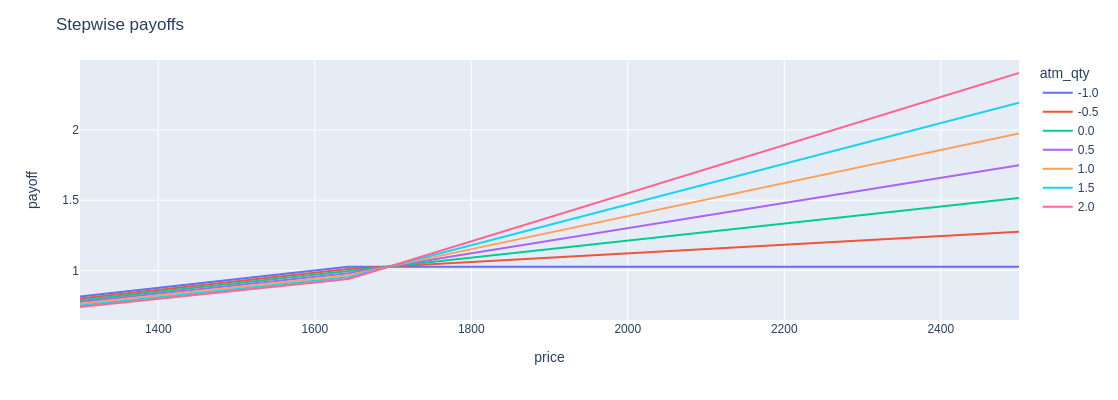

In [5]:
def compute_stepwise_payoff(x, atm_qty, price, time, theta):
    return x + atm_qty * np.maximum(x - price, 0)


def compute_stepwise_price(atm_qty, price, time, vol, kappa, theta, nu, rho):
    def closure(x):
        prob = heston.pdf(x, price, time, vol, 0, kappa, theta, nu, rho)
        payoff = compute_stepwise_payoff(x, atm_qty, price, time, theta)
        return prob * payoff
    return quad(closure, 0, price)[0] + quad(closure, price, np.inf)[0]


def compute_stepwise_functional(atm_qty, price, time, vol, mu, kappa, theta, nu, rho):
    stepwise_price = compute_stepwise_price(atm_qty, price, time, vol, kappa, theta, nu, rho)
    def closure(x):
        prob = heston.pdf(x, price, time, vol, mu, kappa, theta, nu, rho)
        payoff = compute_stepwise_payoff(x, atm_qty, price, time, theta)
        return prob * np.log(payoff / stepwise_price)
    return quad(closure, 0, price_grid[-1])[0]


atm_qties = np.array([-1, -0.5, 0, 0.5, 1, 1.5, 2])
stepwise_payoffs = compute_stepwise_payoff(price_grid[:, None], atm_qties, price, time, theta)
stepwise_prices = np.array([compute_stepwise_price(atm_qty, price, time, vol, kappa, theta, nu, rho) for atm_qty in atm_qties])
payoffs = pd.DataFrame(
    {
        'payoff': (stepwise_payoffs / stepwise_prices).ravel(),
        'price': np.broadcast_to(price_grid[:, None], stepwise_payoffs.shape).ravel(),
        'atm_qty': np.broadcast_to(atm_qties, stepwise_payoffs.shape).ravel(),
    }
)
fig = px.line(payoffs, x='price', y='payoff', color='atm_qty')
fig.update_layout(
    title="Stepwise payoffs",
    height=400,
    width=600,
)
fig.show()

/home/doug/git/fyne/src/fyne/heston.py:806: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

/home/doug/git/fyne/src/fyne/heston.py:806: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

/tmp/ipykernel_2435/2318320339.py:10: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

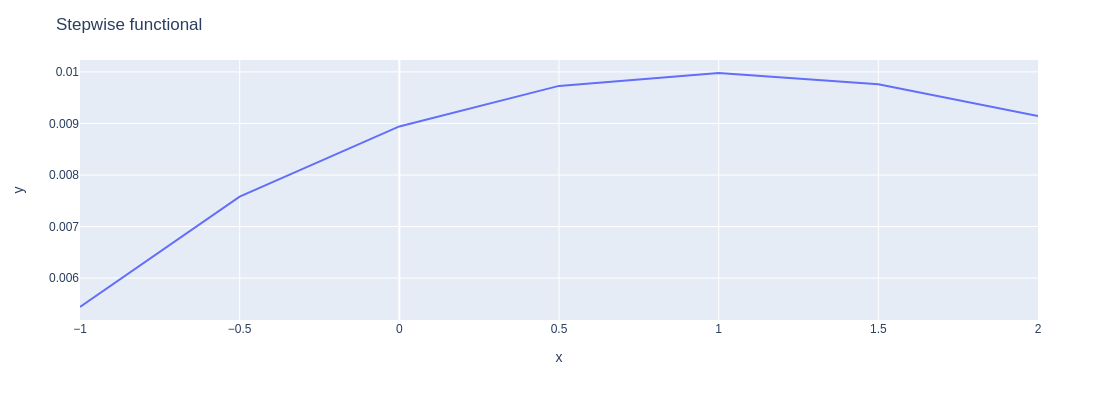

In [6]:
functionals = [compute_stepwise_functional(atm_qty, price, time, vol, mu, kappa, theta, nu, rho) for atm_qty in atm_qties]
fig = px.line(x=atm_qties, y=functionals)
fig.update_layout(
    title="Stepwise functional",
    height=400,
    width=600,
)
fig.show()

/home/doug/git/fyne/src/fyne/heston.py:806: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

/home/doug/git/fyne/src/fyne/heston.py:806: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

/tmp/ipykernel_2435/3571607547.py:10: IntegrationWarning:

The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.

/tmp/ipykernel_2435/3571607547.py:10: IntegrationWarning:

The integ

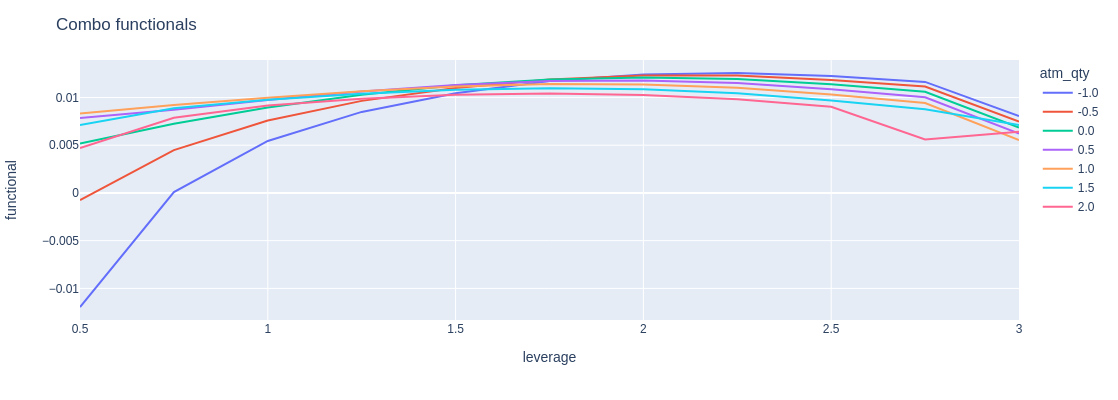

In [7]:
def compute_combo_payoff(x, leverage, atm_qty, price, time, theta):
    return (x / price) ** leverage + (atm_qty / leverage) * np.maximum(x - price, 0) / price


def compute_combo_price(leverage, atm_qty, price, time, vol, kappa, theta, nu, rho):
    def closure(x):
        prob = heston.pdf(x, price, time, vol, 0, kappa, theta, nu, rho)
        payoff = compute_combo_payoff(x, leverage, atm_qty, price, time, theta)
        return prob * payoff
    return quad(closure, 0, price)[0] + quad(closure, price, np.inf)[0]


def compute_combo_functional(leverage, atm_qty, price, time, vol, mu, kappa, theta, nu, rho):
    stepwise_price = compute_combo_price(leverage, atm_qty, price, time, vol, kappa, theta, nu, rho)
    def closure(x):
        prob = heston.pdf(x, price, time, vol, mu, kappa, theta, nu, rho)
        payoff = compute_combo_payoff(x, leverage, atm_qty, price, time, theta)
        return prob * np.log(payoff / stepwise_price)
    return quad(closure, 0, price_grid[-1])[0]


leverages = np.linspace(0.5, 3, 11)
functionals = np.array(
    [
        [compute_combo_functional(leverage, atm_qty, price, time, vol, mu, kappa, theta, nu, rho) for atm_qty in atm_qties]
        for leverage in leverages
    ]
)
data = pd.DataFrame(
    {
        'functional': functionals.ravel(),
        'leverage': np.broadcast_to(leverages[:, None], functionals.shape).ravel(),
        'atm_qty': np.broadcast_to(atm_qties, functionals.shape).ravel(),
    }
)
fig = px.line(data, x='leverage', y='functional', color='atm_qty')
fig.update_layout(
    title="Combo functionals",
    height=400,
    width=600,
)
fig.show()

In [8]:
def compute_binned_payoff(x, bins):
    return 


def compute_combo_price(leverage, atm_qty, price, time, vol, kappa, theta, nu, rho):
    def closure(x):
        prob = heston.pdf(x, price, time, vol, 0, kappa, theta, nu, rho)
        payoff = compute_combo_payoff(x, leverage, atm_qty, price, time, theta)
        return prob * payoff
    return quad(closure, 0, price)[0] + quad(closure, price, np.inf)[0]


def compute_combo_functional(leverage, atm_qty, price, time, vol, mu, kappa, theta, nu, rho):
    stepwise_price = compute_combo_price(leverage, atm_qty, price, time, vol, kappa, theta, nu, rho)
    def closure(x):
        prob = heston.pdf(x, price, time, vol, mu, kappa, theta, nu, rho)
        payoff = compute_combo_payoff(x, leverage, atm_qty, price, time, theta)
        return prob * np.log(payoff / stepwise_price)
    return quad(closure, 0, price_grid[-1])[0]

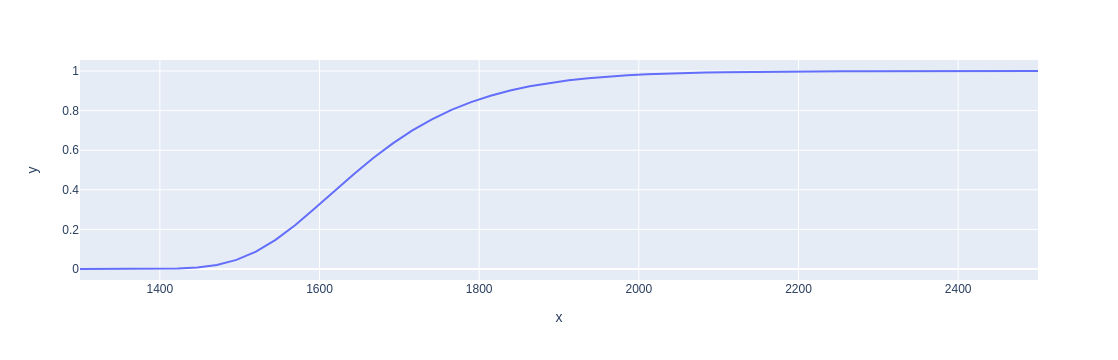

In [9]:
def compute_heston_cdf(x, price, time, vol, mu, kappa, theta, nu, rho):
    return quad(lambda u: heston.pdf(u, price, time, vol, mu, kappa, theta, nu, rho), 0, x)[0]

px.line(x=price_grid, y=[compute_heston_cdf(x, price, time, vol, mu, kappa, theta, nu, rho) for x in price_grid]).show()

In [10]:
from scipy.optimize import minimize


def compute_binned_functional(log_weights_ex_first, bin_edges, bin_probs, bin_probs_neutral):
    weights = np.ones_like(bin_probs)
    weights[1:] = np.exp(log_weights_ex_first)
    binned_price = weights @ bin_probs_neutral
    return np.log(weights / binned_price) @ bin_probs

n_bins = 20
bin_edges = np.linspace(price_grid[0], price_grid[-1], n_bins + 1)
bin_probs = np.array(
    [
        quad(lambda u: heston.pdf(u, price, time, vol, mu, kappa, theta, nu, rho), a, b)[0]
        for a, b in zip(bin_edges[:-1], bin_edges[1:])
    ]
)
bin_probs_neutral = np.array(
    [
        quad(lambda u: heston.pdf(u, price, time, vol, 0, kappa, theta, nu, rho), a, b)[0]
        for a, b in zip(bin_edges[:-1], bin_edges[1:])
    ]
)

optimal_log_weights = minimize(lambda x: -compute_binned_functional(x, bin_edges, bin_probs, bin_probs_neutral), np.log(2 + np.arange(n_bins - 1)))
optimal_log_weights

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.015243486174408358
        x: [ 1.292e+00  1.574e+00 ...  2.361e+00  2.441e+00]
      nit: 135
      jac: [ 2.662e-06  2.367e-06 ... -5.362e-06  3.223e-06]
 hess_inv: [[ 4.159e+02  3.151e+01 ... -2.078e+01  1.949e+02]
            [ 3.151e+01  8.519e+01 ... -1.433e+01  1.851e+02]
            ...
            [-2.078e+01 -1.433e+01 ...  3.080e+03  4.036e+03]
            [ 1.949e+02  1.851e+02 ...  4.036e+03  6.299e+03]]
     nfev: 2720
     njev: 136

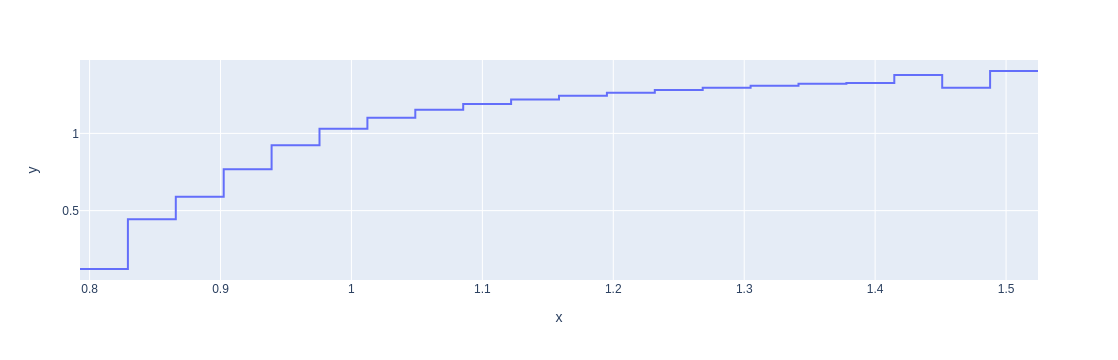

In [11]:
optimal_weights = np.ones(n_bins)
optimal_weights[1:] = np.exp(optimal_log_weights.x)
binned_price = optimal_weights @ bin_probs_neutral
optimal_weights /= binned_price
fig = px.line(x=bin_edges / price, y=[optimal_weights[0], *optimal_weights], line_shape='vh')
fig.show()

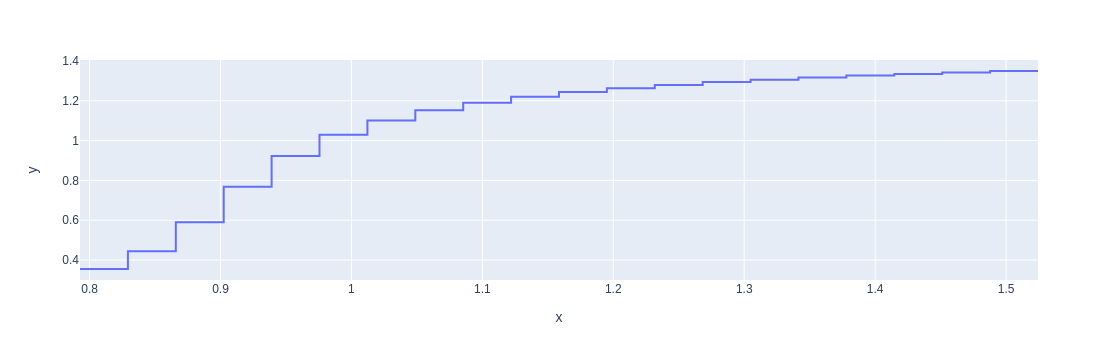

In [14]:
radon_nikodym = bin_probs / bin_probs_neutral
fig = px.line(x=bin_edges / price, y=[radon_nikodym[0], *radon_nikodym], line_shape='vh')
fig.show()

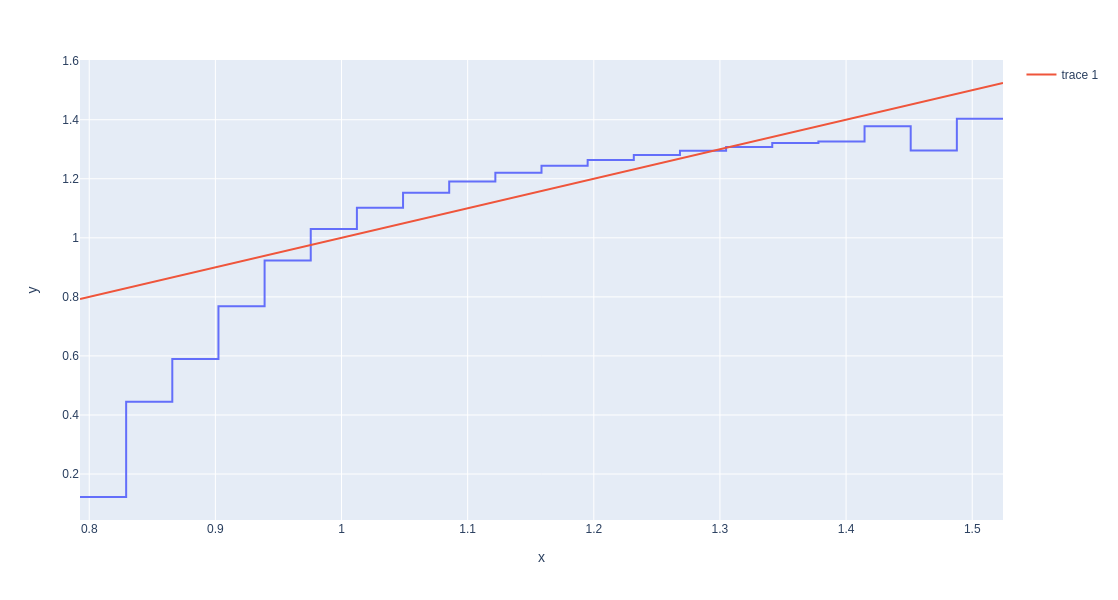

In [55]:
fig = px.line(x=bin_edges / price, y=[optimal_weights[0], *optimal_weights], line_shape='vh')
fig.add_trace(
    go.Scatter(
        x=bin_edges / price,
        y=bin_edges / price,
        mode="lines",
    )
)
fig.update_layout(
    width=800,
    height=600,
)
fig.show()

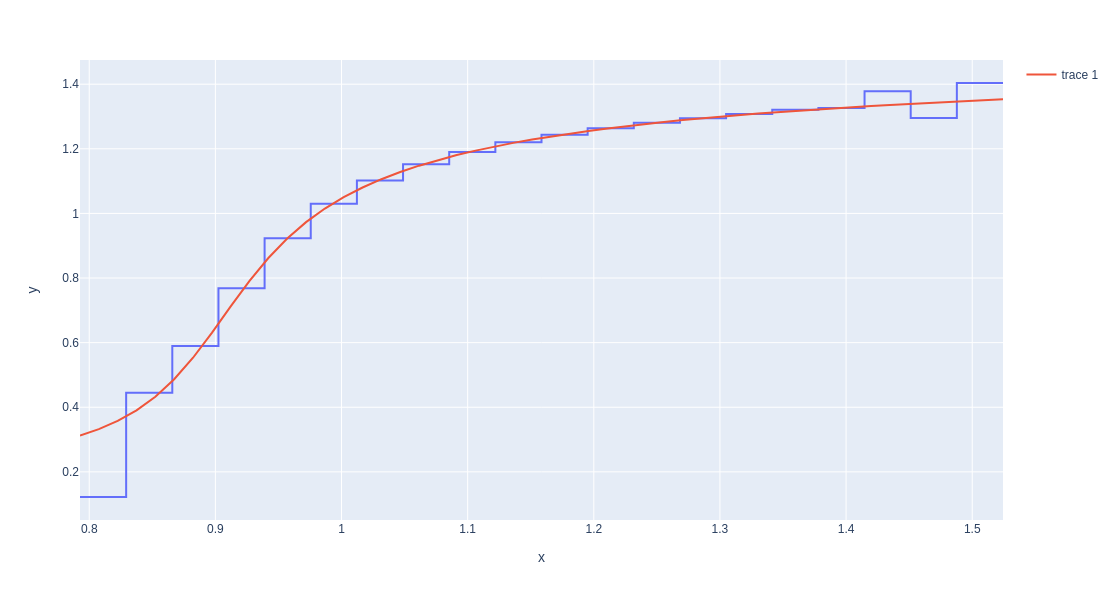

In [17]:
fig = px.line(x=bin_edges / price, y=[optimal_weights[0], *optimal_weights], line_shape='vh')
fig.add_trace(
    go.Scatter(
        x=price_grid / price,
        y=np.array(pdf_prices) / np.array(pdf_prices_neutral),
        mode="lines",
    )
)
fig.update_layout(
    width=800,
    height=600,
)
fig.show()

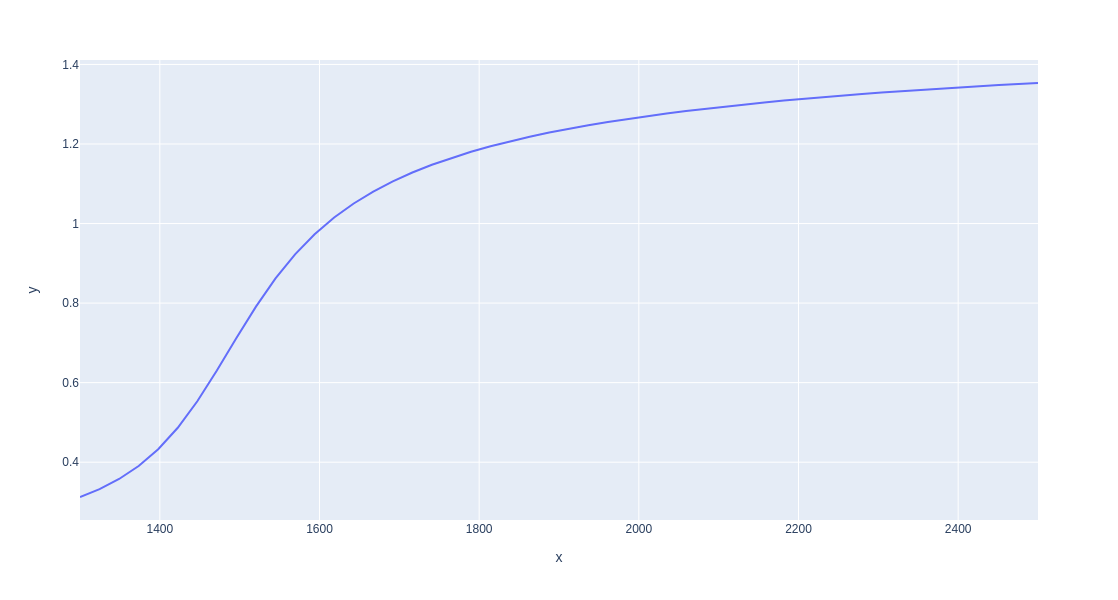

In [18]:
fig = px.line(x=price_grid, y=np.array(pdf_prices) / np.array(pdf_prices_neutral))
fig.update_layout(
    width=800,
    height=600,
)
fig.show()

In [46]:
-optimal_log_weights.fun

0.015243486174408358

In [48]:
np.exp(-12 * optimal_log_weights.fun)

1.2007205490017026

In [50]:
np.exp(12 * 0.012)

1.1548841085249137